In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Use the following lines to test the basic functionality of the package if developing locally: 
import sys, os
sys.path.insert(0, "../src/")
from graph import *

This notebook showcases the first few steps of the Omics Integrator network analysis pipeline: 
1. Parameter selection
2. Randomization experiments

In order to use the inline R visualizations, please follow the setup instructions [here](https://www.datacamp.com/community/blog/jupyter-notebook-r).

In [2]:
# Load R plotting libraries
%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr)

array([1], dtype=int32)

In [10]:
%%R 

library(ComplexHeatmap)
library(circlize)
library(colorspace)

plotHeatmap <- function(nodes, node_attributes, name=" ") {
"Visualizes a heatmap of summarized experiments generated by `summarize_grid_search`.

Arguments:
    nodes (df): Values summarized across experiments
    node_attributes (df): node attributes columns"
    
    # Get values to display parameter colorbars
    tmp <- data.frame(do.call(rbind, strsplit(colnames(nodes), '_', fixed=TRUE)))[,c(2,4,6)]
    colnames(tmp) <- c("w", "b", "g")
    indx <- sapply(tmp, is.factor)
    tmp[indx] <- lapply(tmp[indx], function(x) as.numeric(as.character(x)))
    tmp$g <- log10(tmp$g)
    
    node_attributes$log10_degree <- log10(node_attributes$degree)
    node_attributes <- node_attributes[rownames(nodes),c("prize", "type", "log10_degree")]

    # Top annotation
    ha = HeatmapAnnotation(
        df=node_attributes, 
        col=list(
            prize = colorRamp2(c(0,max(node_attributes$prize)), c("white", "orange")), 
            type=c("steiner"="blue", "terminal"="red", "TF"="green"),
            log10_degree=colorRamp2(c(0,1.5,max(node_attributes$log10_degree)), c("blue", "white", "red"))
        ), 
        annotation_legend_param=list(
            prize=list(legend_direction="horizontal"),
            type=list(legend_direction="horizontal"), 
            log10_degree=list(legend_direction="horizontal")
        )
    )

    ht = Heatmap(
        t(nodes), 
        name=name, 
        col=c("white", "black"), 
        show_column_names=F, 
        top_annotation=ha, 
        top_annotation_height=unit(12, "mm")
    ) + 
        Heatmap(tmp$w, name="W", col=colorRamp2(c(0, max(tmp$w)), c("white", "red")), width=unit(6, "mm")) +
        Heatmap(tmp$b, name="B", col=colorRamp2(c(0, max(tmp$b)), c("white", "blue")), width=unit(6, "mm")) +
        Heatmap(tmp$g, name="G", col=colorRamp2(c(0, max(tmp$g)), c("white", "green")), width=unit(6, "mm"))

    draw(ht, heatmap_legend_side = "right", annotation_legend_side = "top")
}

# 0. Omics Integrator 2 Inputs

In [4]:
interactome_file = "/Users/jonathanli/Documents/research/ALS/data/interactome/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
prize_file = "/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/prizes.txt"
output_dir = "/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/"

Ws = [0.25, 0.5, 0.75, 1]
Bs = [0.25, 0.5, 0.75, 1]
Gs = [1000, 3000, 10000, 30000]

params = {
    "noise": 0.1, 
    "dummy_mode": "terminals", 
    "exclude_terminals": False, 
    "seed": 1
}

graph = Graph(interactome_file, params)
graph.prepare_prizes(prize_file)

10:49:50 - Graph: INFO - Duplicated edges in the interactome file (we'll keep the max cost):
10:49:50 - Graph: INFO - []
10:49:52 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:49:52 - Graph: INFO - ['HNRNPA2B1']
10:49:52 - Graph: INFO - Members of the prize file not present in the interactome:
10:49:52 - Graph: INFO - []


In [5]:
# Format of prize file
pd.read_csv(prize_file, sep='\t').head()

,name,prize,type
0,ANXA2,1.149461,terminal
1,ATM,0.453498,terminal
2,BDH2,0.472954,terminal
3,CBX1,0.895977,terminal
4,CBX3,0.479893,terminal


In [6]:
node_attributes_df = graph.node_attributes

In [7]:
node_attributes_df.head()

,prize,type,degree
C9ORF72,4.0,terminal,92
ZNF91,0.0,steiner,6
ACP5,0.0,steiner,11
SLC27A2,0.0,steiner,9
PAX9,0.0,steiner,11


# 1. Parameter sweep
We perform this parameter sweep to check that the parameter search space is reasonable. We don't want parameters that produce mostly empty networks, nor do we want parameter sets that produce very similar solutions. 

In [9]:
results = graph.grid_search(prize_file, Ws, Bs, Gs)

10:51:03 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:51:03 - Graph: INFO - ['HNRNPA2B1']
10:51:03 - Graph: INFO - Members of the prize file not present in the interactome:
10:51:03 - Graph: INFO - []
10:51:04 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_1000
10:51:04 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_10000
10:51:05 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_1000
10:51:05 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_10000
10:51:06 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_3000
10:51:07 - Graph: INFO - Single PCSF runs for W_0.25_B_0.75_G_1000
10:51:07 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_30000
10:51:07 - Graph: INFO - Single PCSF runs for W_0.25_B_0.75_G_10000
10:51:07 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_3000
10:51:08 - Graph: INFO - Single PCSF runs for W_0.25_B_1.00_G_1000
10:51:08 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_30000
10:51:08 - Gr

Summarize the results into a membership dataframe and visualize the results as a heatmap. 

In [11]:
membership_df = summarize_grid_search(results, "membership")

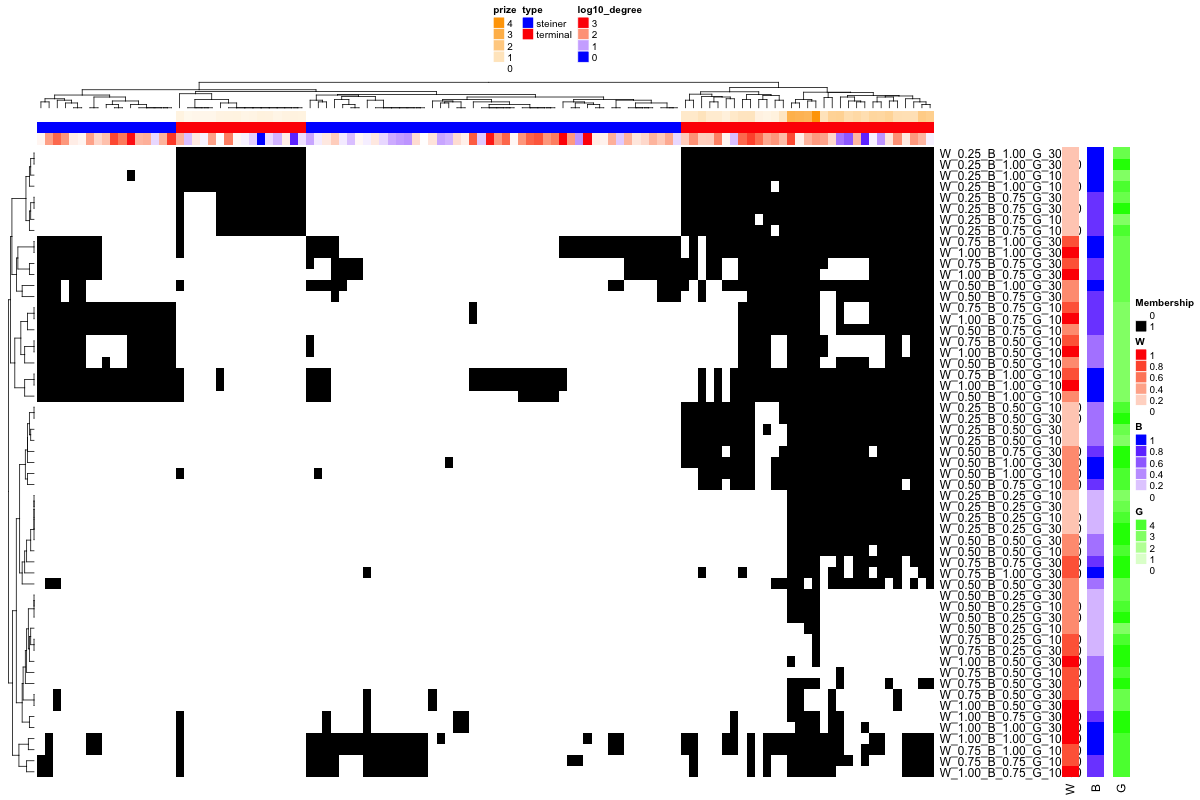

In [12]:
%%R -i membership_df,node_attributes_df -w 1200 -h 800 -u px
plotHeatmap(membership_df, node_attributes_df, "Membership")

# 2. Randomization

If we are happy with the parameter space, we run randomization experiments to evaluate the robustness and specificity of our solutions. 

1. We add noise to our interactome and average over many runs (typically `100`, but in this notebook `5`). **Robustness** is the proportion of runs in which a given node appears. 
2. We shuffle the labels of the input prizes and assign them to random nodes in the interactome. **Specificity** is the proportion of runs in which a given node appears. Nodes with a high specificity score are not specific to the input prizes. 

In [8]:
robustness_reps = 5
specificity_reps = 5

results = graph.grid_randomization(prize_file, Ws, Bs, Gs, robustness_reps, specificity_reps)

10:30:23 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:30:24 - Graph: INFO - ['HNRNPA2B1']
10:30:24 - Graph: INFO - Members of the prize file not present in the interactome:
10:30:24 - Graph: INFO - []
10:30:25 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_1000
10:30:26 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_10000
10:30:26 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_1000
10:30:27 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_10000
10:30:27 - Graph: INFO - Randomizations for W_0.25_B_0.75_G_1000
10:30:28 - Graph: INFO - Randomizations for W_0.25_B_0.75_G_10000
10:30:28 - Graph: INFO - Randomizations for W_0.25_B_1.00_G_1000
10:30:29 - Graph: INFO - Randomizations for W_0.25_B_1.00_G_10000
10:30:30 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_3000
10:30:30 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_30000
10:30:31 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_3000
10:30:31 - Graph: INFO - Randomizat

The merged solutions over many runs will be quite large (1000s of nodes), so for each parameter set, we will generate a subnetwork composed of highly robust nodes. Here, allow robust networks to be a maximum of `400` nodes, and remove any components with fewer than `5` nodes. 

In [11]:
for paramstring, forests in results.items(): 
    forests["robust"] = get_robust_subgraph_from_randomizations(forests["augmented_forest"], 400, 5)

We summarize the results into robustness and specificity dataframes and visualize the results as heatmaps. In general, we prefer parameters that don't simply incorporate all terminal nodes, but include Steiner nodes as well. Furthermore, we avoid parameter sets that contain many non-specific nodes. 

In [12]:
robustness_df = summarize_grid_search(results, "robustness", top_n=1000)
specificity_df = summarize_grid_search(results, "specificity", top_n=1000)

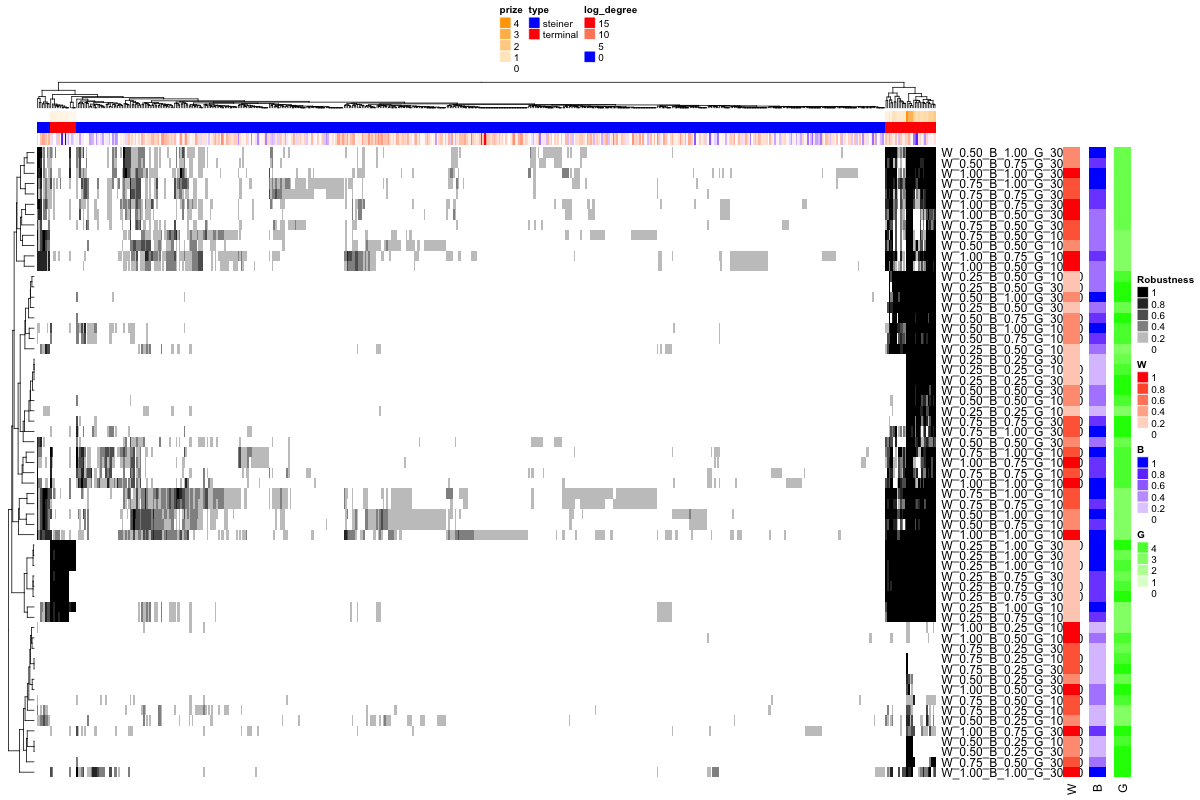

In [13]:
%%R -i robustness_df,node_attributes_df -w 1200 -h 800 -u px
plotHeatmap(robustness_df, node_attributes_df, "Robustness")

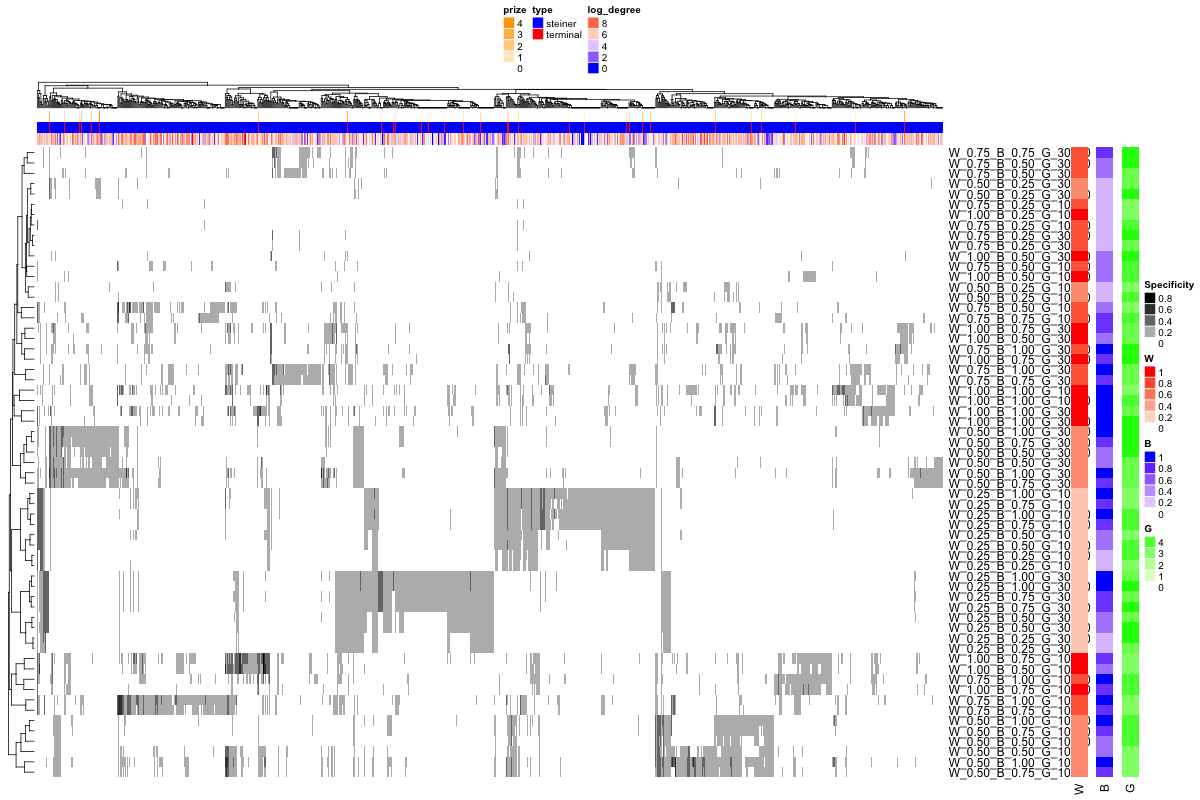

In [14]:
%%R -i specificity_df,node_attributes_df -w 1200 -h 800 -u px
plotHeatmap(specificity_df, node_attributes_df, "Specificity")

# 3. Output networkx graph

After selecting a suitable parameter set, we can output the robust network as a `.graphml` file, which can be imported into Cytoscape for further visualization. 

In [15]:
parameter_set = "W_0.25_B_0.50_G_10000"

output_networkx_graph_as_graphml_for_cytoscape(results[parameter_set]["robust"], 
                                               output_dir=output_dir, 
                                               filename="{}.robust_network.graphml".format(parameter_set))

'/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/W_0.25_B_0.50_G_10000.robust_network.graphml'